In [1]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import label_map_util
from utils import visualization_utils as vis_util
import random

%matplotlib inline

In [2]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [3]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH = r'models/ssd_udacity/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'data/udacity_label_map.pbtxt'
NUM_CLASSES = 13

In [4]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [5]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [6]:
IMAGE_SIZE = (12, 8)

SCORES
[0.9508856  0.02945291 0.0254942  0.02471821 0.02376335 0.0226079
 0.02188586 0.02146913 0.0214444  0.02107673]
CLASSES
[2. 3. 3. 3. 4. 1. 1. 2. 4. 4.]


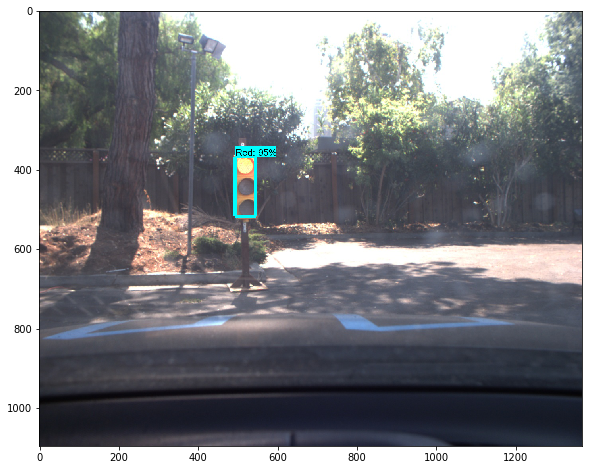

SCORES
[0.9803171  0.03118407 0.03000619 0.02997198 0.02816222 0.02733944
 0.02688365 0.02686886 0.02651343 0.02633769]
CLASSES
[1. 1. 3. 2. 2. 2. 3. 1. 3. 4.]


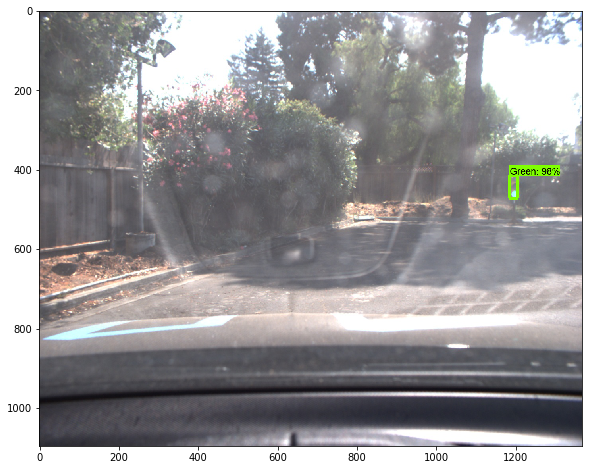

SCORES
[0.74481946 0.05508053 0.03583155 0.03221644 0.02874665 0.02720523
 0.0262743  0.0262691  0.02540525 0.02421459]
CLASSES
[1. 1. 4. 4. 2. 2. 3. 2. 1. 3.]


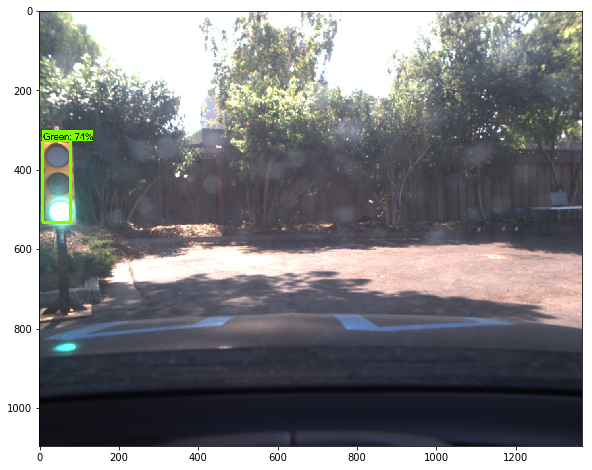

SCORES
[0.81343067 0.0359265  0.0244958  0.02171687 0.02148609 0.02076191
 0.0207567  0.02068023 0.02048339 0.01981911]
CLASSES
[1. 3. 3. 3. 2. 1. 4. 4. 1. 1.]


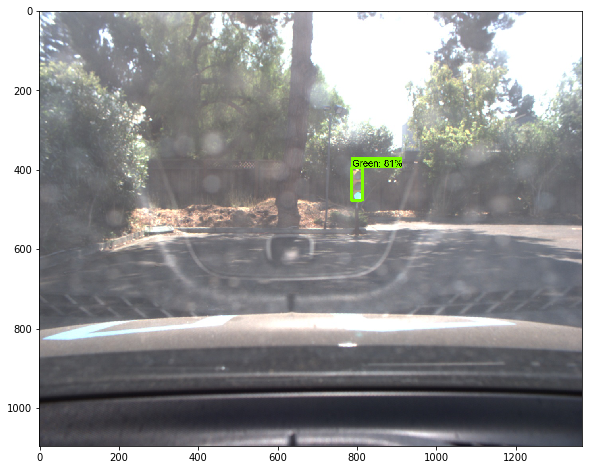

SCORES
[0.03334615 0.03315692 0.02891294 0.02731084 0.02723262 0.02461328
 0.02419379 0.02332173 0.02319667 0.02252628]
CLASSES
[1. 3. 1. 1. 1. 1. 3. 1. 1. 1.]


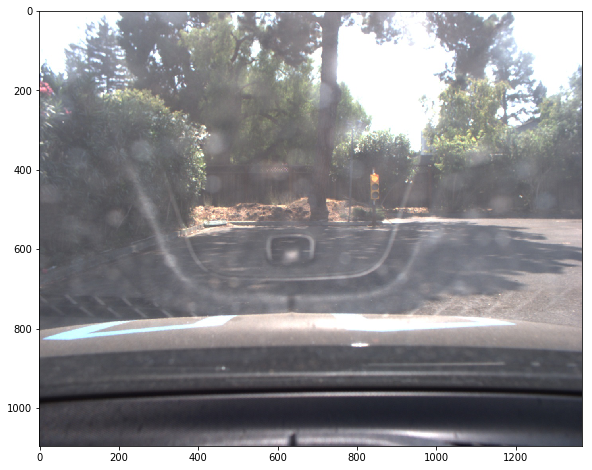

SCORES
[0.5306786  0.04019547 0.03805515 0.02580015 0.02401507 0.02346014
 0.0233491  0.02325931 0.02211214 0.02199029]
CLASSES
[1. 3. 1. 2. 1. 1. 1. 1. 2. 3.]


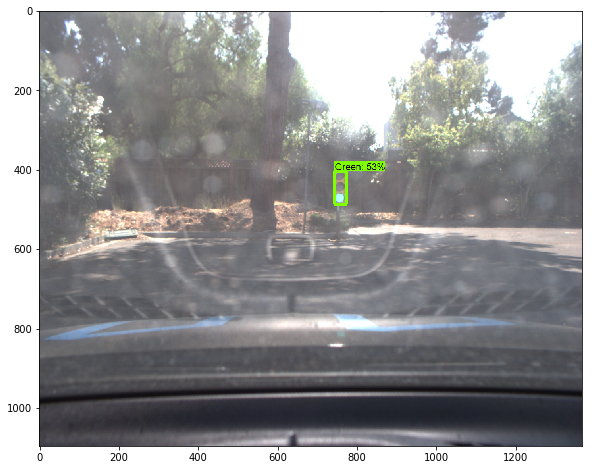

SCORES
[0.97519624 0.03011125 0.02788093 0.02781139 0.0273098  0.02726662
 0.02632185 0.02620787 0.02573289 0.0248074 ]
CLASSES
[1. 3. 2. 4. 4. 2. 3. 3. 3. 1.]


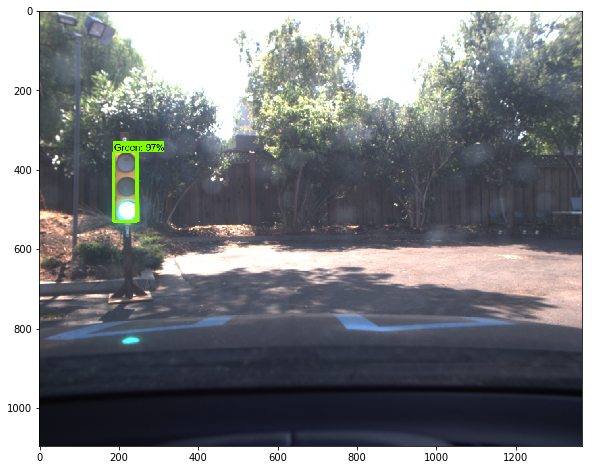

SCORES
[0.4600461  0.06666617 0.02698432 0.02617588 0.02286233 0.02276757
 0.02177341 0.02162109 0.02114341 0.02095914]
CLASSES
[2. 3. 4. 3. 3. 3. 4. 3. 1. 2.]


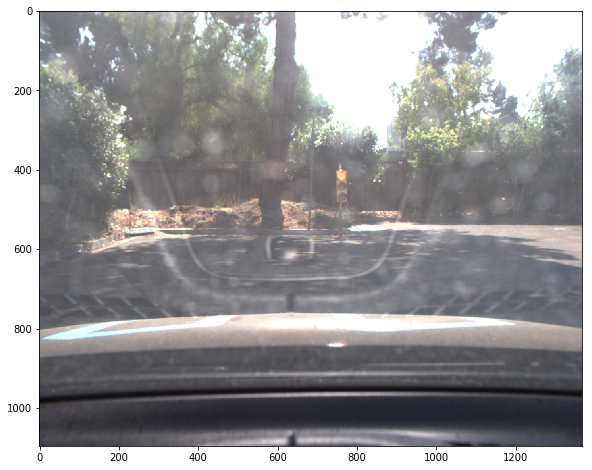

SCORES
[0.95302445 0.03141816 0.02720857 0.02582753 0.02563052 0.024184
 0.02364065 0.02363229 0.02340996 0.02298934]
CLASSES
[1. 4. 3. 4. 3. 4. 1. 1. 4. 3.]


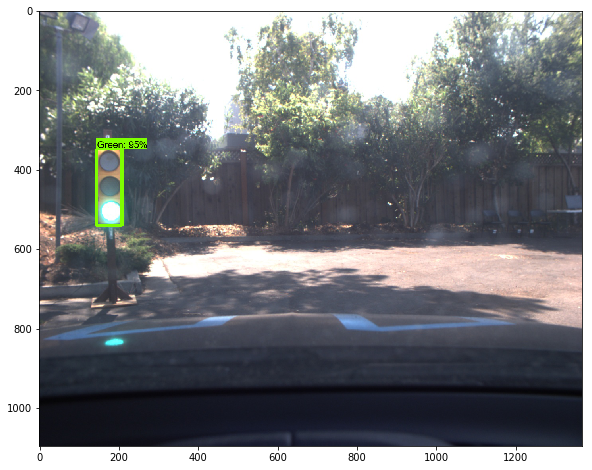

SCORES
[0.9066122  0.04011562 0.02721724 0.02372321 0.02308514 0.02266911
 0.02211069 0.02178161 0.02129682 0.0208318 ]
CLASSES
[1. 1. 2. 1. 4. 2. 1. 1. 3. 1.]


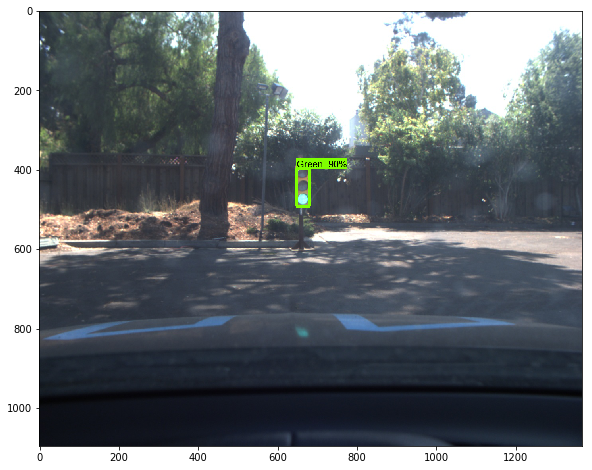

SCORES
[0.8694489  0.02701479 0.02543646 0.02438907 0.0234744  0.02322709
 0.02300706 0.02207375 0.02197992 0.02151111]
CLASSES
[2. 3. 2. 4. 3. 4. 1. 2. 4. 1.]


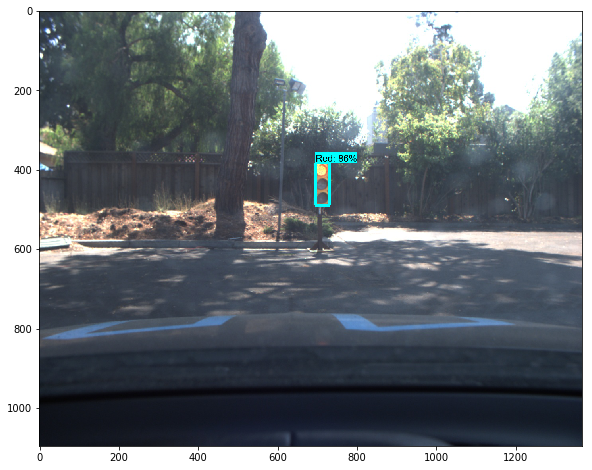

In [7]:
PATH_TO_IMGS = r'data/udacity_testarea_rgb'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            random.shuffle(TEST_IMGS)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break

In [8]:
PATH_TO_GRAPH = r'models/ssd_sim/frozen_inference_graph.pb' ## load SSD trained on udacity's simulator images
detection_graph = load_graph(PATH_TO_GRAPH)

SCORES
[0.99456304 0.98578346 0.01670949 0.00825321 0.0079201  0.00746307
 0.00575944 0.00568984 0.00562876 0.00540954]
CLASSES
[2. 2. 2. 2. 2. 3. 4. 2. 4. 4.]


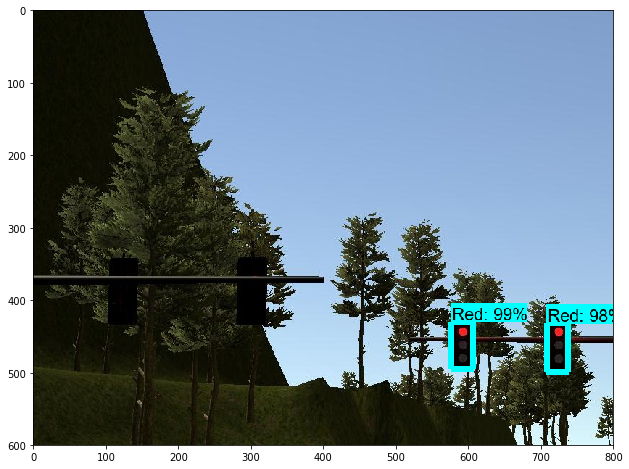

SCORES
[0.99948907 0.9987078  0.97994334 0.00502719 0.00485199 0.00483135
 0.00481754 0.00444233 0.00434587 0.00424747]
CLASSES
[2. 2. 2. 2. 4. 1. 2. 4. 3. 2.]


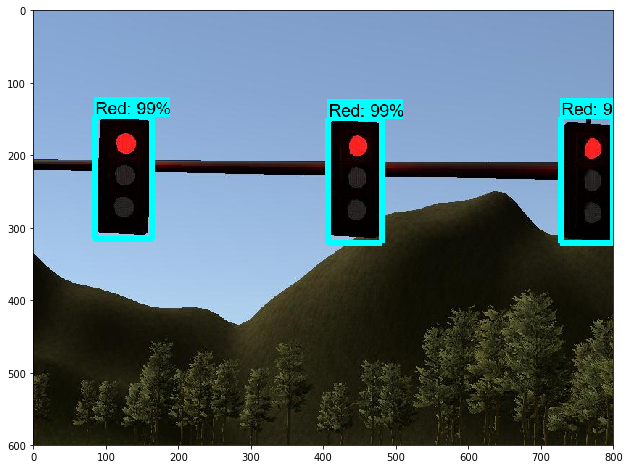

SCORES
[0.88549787 0.7229444  0.5377118  0.00666254 0.00599447 0.00548193
 0.00531469 0.00510492 0.00508822 0.00495981]
CLASSES
[2. 2. 2. 2. 2. 2. 2. 3. 4. 3.]


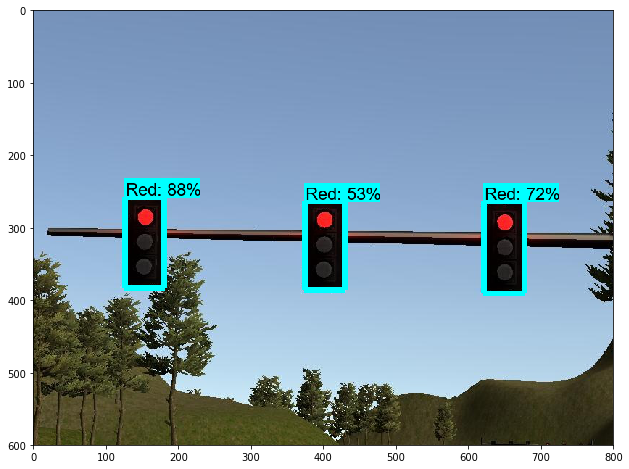

SCORES
[0.00457505 0.0044674  0.00446403 0.00439052 0.00428835 0.00423297
 0.00420832 0.00411604 0.00408237 0.00406824]
CLASSES
[4. 2. 4. 1. 4. 2. 4. 1. 1. 4.]


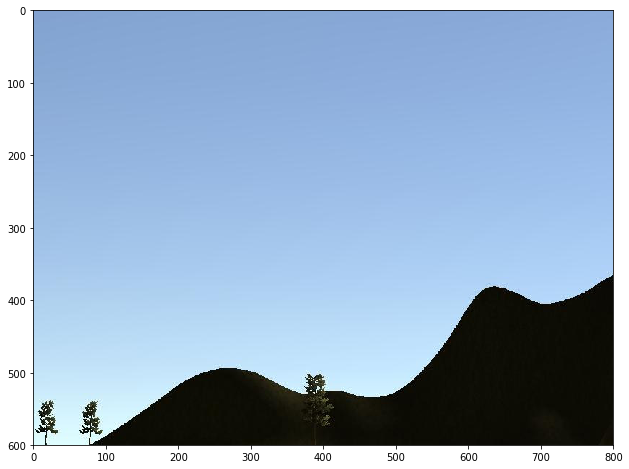

SCORES
[0.00846644 0.00803026 0.00684512 0.00668108 0.00656448 0.00644651
 0.0063139  0.00596688 0.00592175 0.0057979 ]
CLASSES
[1. 2. 2. 2. 3. 3. 3. 1. 2. 1.]


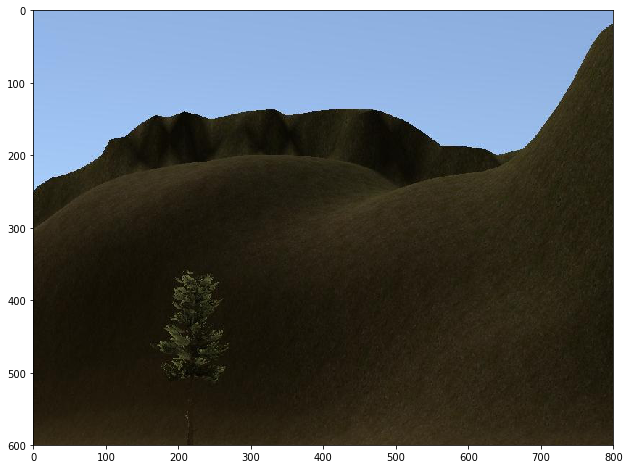

SCORES
[0.99936897 0.99788874 0.96993476 0.00483109 0.0047877  0.0044478
 0.00418599 0.00415625 0.0040999  0.00407193]
CLASSES
[2. 2. 2. 2. 4. 4. 2. 4. 1. 2.]


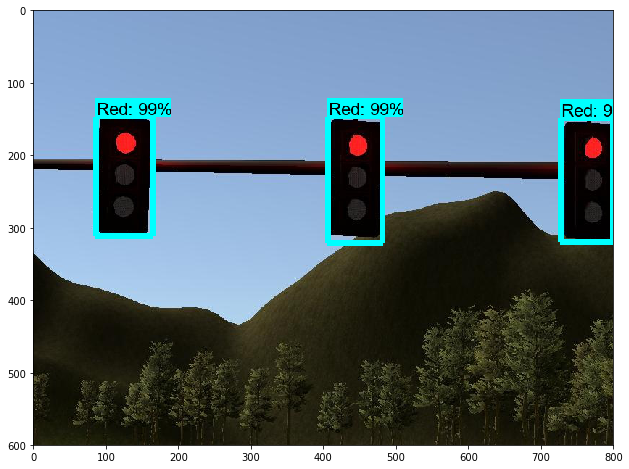

SCORES
[0.9935534  0.78023046 0.73579407 0.01311983 0.00727968 0.00704404
 0.00655296 0.00645179 0.00607176 0.0056883 ]
CLASSES
[1. 1. 1. 1. 2. 1. 2. 1. 1. 3.]


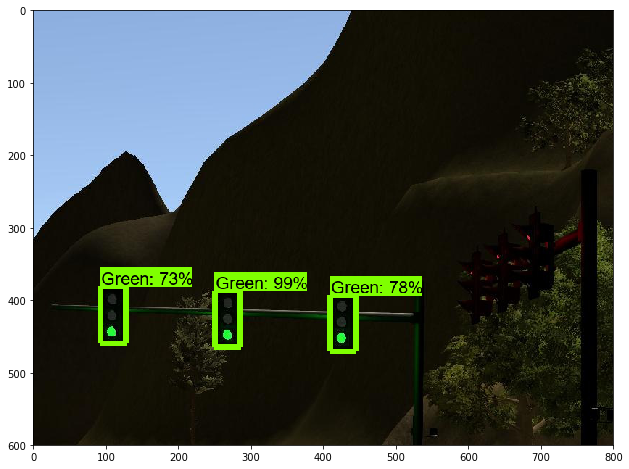

SCORES
[0.99281764 0.9428749  0.9094864  0.02578995 0.01500733 0.00614413
 0.00597352 0.00537702 0.00531348 0.00518326]
CLASSES
[1. 1. 1. 1. 1. 1. 1. 4. 2. 1.]


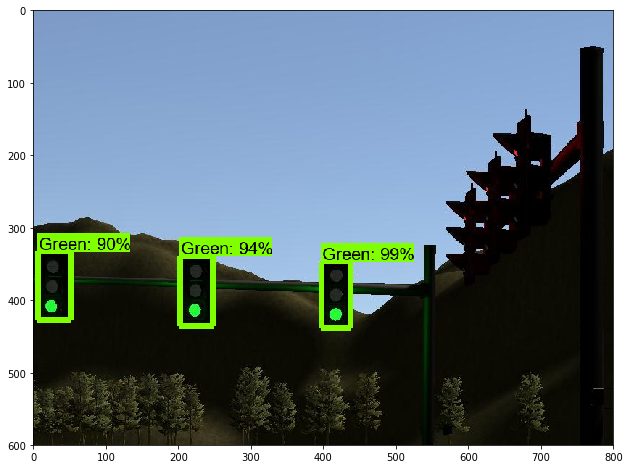

SCORES
[0.8814997  0.8138649  0.38313314 0.00507292 0.00453252 0.00417033
 0.00416637 0.0041059  0.00407147 0.00398269]
CLASSES
[1. 1. 1. 1. 4. 4. 4. 3. 4. 1.]


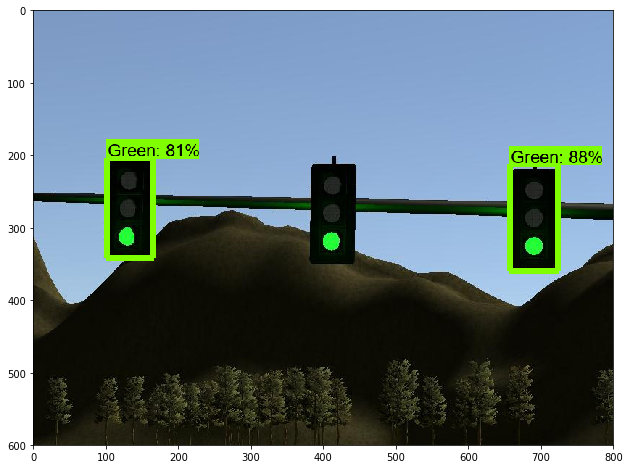

SCORES
[0.00886897 0.00864935 0.00573267 0.0056512  0.00563185 0.00549438
 0.00520855 0.00500943 0.00447869 0.00447713]
CLASSES
[3. 2. 1. 2. 3. 4. 4. 4. 1. 4.]


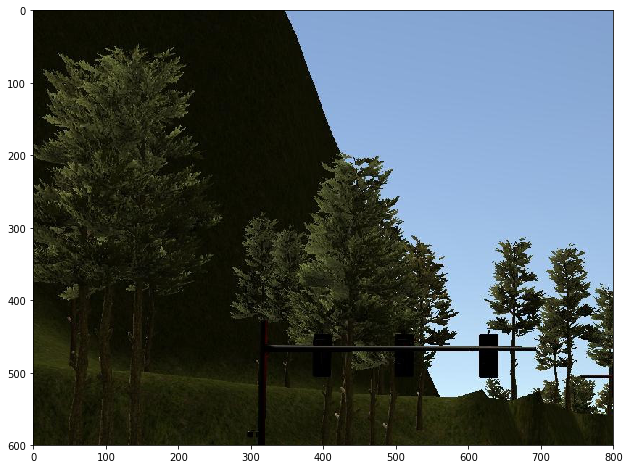

SCORES
[0.9872213  0.97634363 0.5242206  0.01246992 0.0062374  0.00596491
 0.00585272 0.00578688 0.00550447 0.00547401]
CLASSES
[1. 1. 1. 1. 1. 1. 4. 1. 1. 1.]


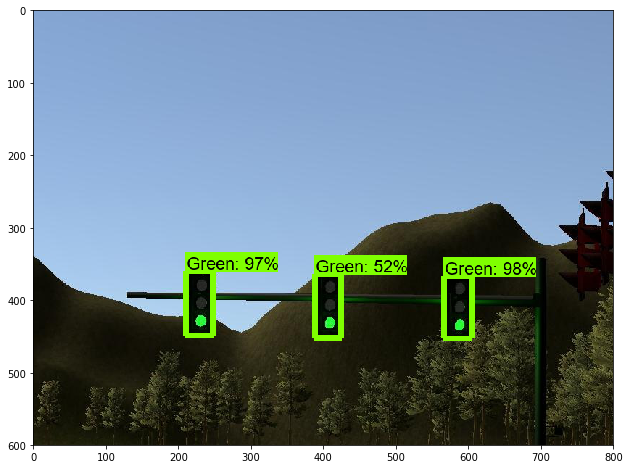

In [9]:
PATH_TO_IMGS = r'data/simulator_dataset_rgb'
subfolder = ['Green', 'Red', 'Yellow', 'Unknown']
TEST_IMGS = []
for i in subfolder:
    TEST_IMGS += glob(os.path.join(os.path.join(PATH_TO_IMGS, i), r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break